In [2]:
import os
from pySMOKEPostProcessor import pySMOKEpostprocessor as pp
from pySMOKEPostProcessor import FluxByClass
from pySMOKEPostProcessor.plots.heatmaps import plot_heatmap
from pySMOKEPostProcessor.plots.heatmaps import save_fig
import matplotlib.pyplot as plt

# Rate Of Production Analysis by Reaction Class
The rate of production analysis can be organized according to reaction classes. Different levels of classification are available:

> * `Class type`: defined by the user in **rxn_class_groups.txt** text file (see data/Classes). Broad classification (e.g., bond-fission, H-abstraction, growth)
> * `Reaction type`: reaction channels belonging to a certain class type. These are listed within the class types in the text file. They must also be present in the **kinetics.xml** file (hard coded)
> * `Species type`: type of species that defines the functional group participating to the reaction (e.g., A1-M is the aromatic ring in its molecular form, A1-R is a phenyl-like radical)
> * `Bimolecular type`: classification according to unimolecular/bimolecular reaction type, accounting for the nature of the reacting species (M, R, RSR: molecule, radical, resonance-stabilized radical). This classification does not require specific input.


Required input for the different steps

* `FluxByClass`: class that handles the classification of reactions. Input arguments are:
    > * `kin_xml_fld` (*str*): path to the folder containing the files relative to the kinetic mechanism named directly, after the pre-processing by OpenSMOKE++: **kinetics.xml** and **reaction_names.xml**.
    > * `class_groups_fld` (*str*): path to the folder containing the **rxn_class_groups.txt** file with the groups.
    
* `FluxByClass.process_flux`: assigns the reaction flux according to the user requests. for now, only global flux analysis is available. This function calls the pySMOKEpostprocessor.RateOfProductionAnalysis. Input arguments are:
    > * `species_list` (*list*): list of species to perform ROPA for
    > * `simul_fld` (*str*): path to the folder containing OpenSMOKE++ output simulation files. **Output.xml** is required.
    > * `ropa_type` (*str*): type of ROPA (global is the only available option for now).
    > * `n_of_rxns` (*int*, default: 100): number of reactions to be included in the flux analysis (from those with the highest flux).
    

* `FluxByClass.sort_and_filter`: organizes classes for each species flux by reaction class and sums fluxes in the same class. filters classes (i.e., reduces the set of reactions considered) by user-defined criteria. requires:
    > * `sortlist` (*list(str)*): criteria to be considered hierarchically for reaction flux sorting. allowed strings: **classtype,speciestype,reactiontype,bimoltype**. For instance, ['speciestype','reactiontype'] groups reactions according to species type, and within that set the reactions are grouped according to reaction type.
    > * `filter_dct` (*dict: list(str)*): filtering for set of classes. dictionary keys correspond to criteria allowed for sortlist, and the value is a list of strings that have to be contained in the class filtered. For instance, {'classtype':['ADD','ABS']} filters all reactions whose classtype includes either 'ADD' or 'ABS' (i.e., abstractions and addition reactions).
    > * `threshold` (*float*): minimum relative flux to be considered in the classification. Reactions with smaller flux will be removed.

In [3]:
base_path = os.getcwd()
kin_xml_fld = os.path.join(base_path, 'data', 'Classes', 'kinetics')
class_groups_fld = os.path.join(base_path, 'data', 'Classes')
plt_fld = os.path.join(base_path, 'Figures')

simul_flds ={'example-c6h6' : os.path.join(base_path, 'data', 'Classes', 'simul', 'Output')}

**Example 1**:
provide a list of species to analyze simulations of benzene oxidation
sort by three different criteria: classtype, speciestype, bimoltype
Each of them is considered separately, so you will get three different datasets and plots. The number of reactions considered for each flux is 200 and the threshold for the relative flux is 1%.

In [4]:
# check output availablity
PostProcessor = pp.pySMOKEpostprocessor(kinetic_mechanism = kin_xml_fld, 
                                     results_folder = simul_flds['example-c6h6'], 
                                     verbose=True)

ROPA available
Computational domain: 
 * Lower Bound: 0.0   Upper Bound: 0.191957
 * Middle value: 0.095978


SystemExit: Unknown system type: PlugFlowReactor

/home/chimica2/lpratali/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


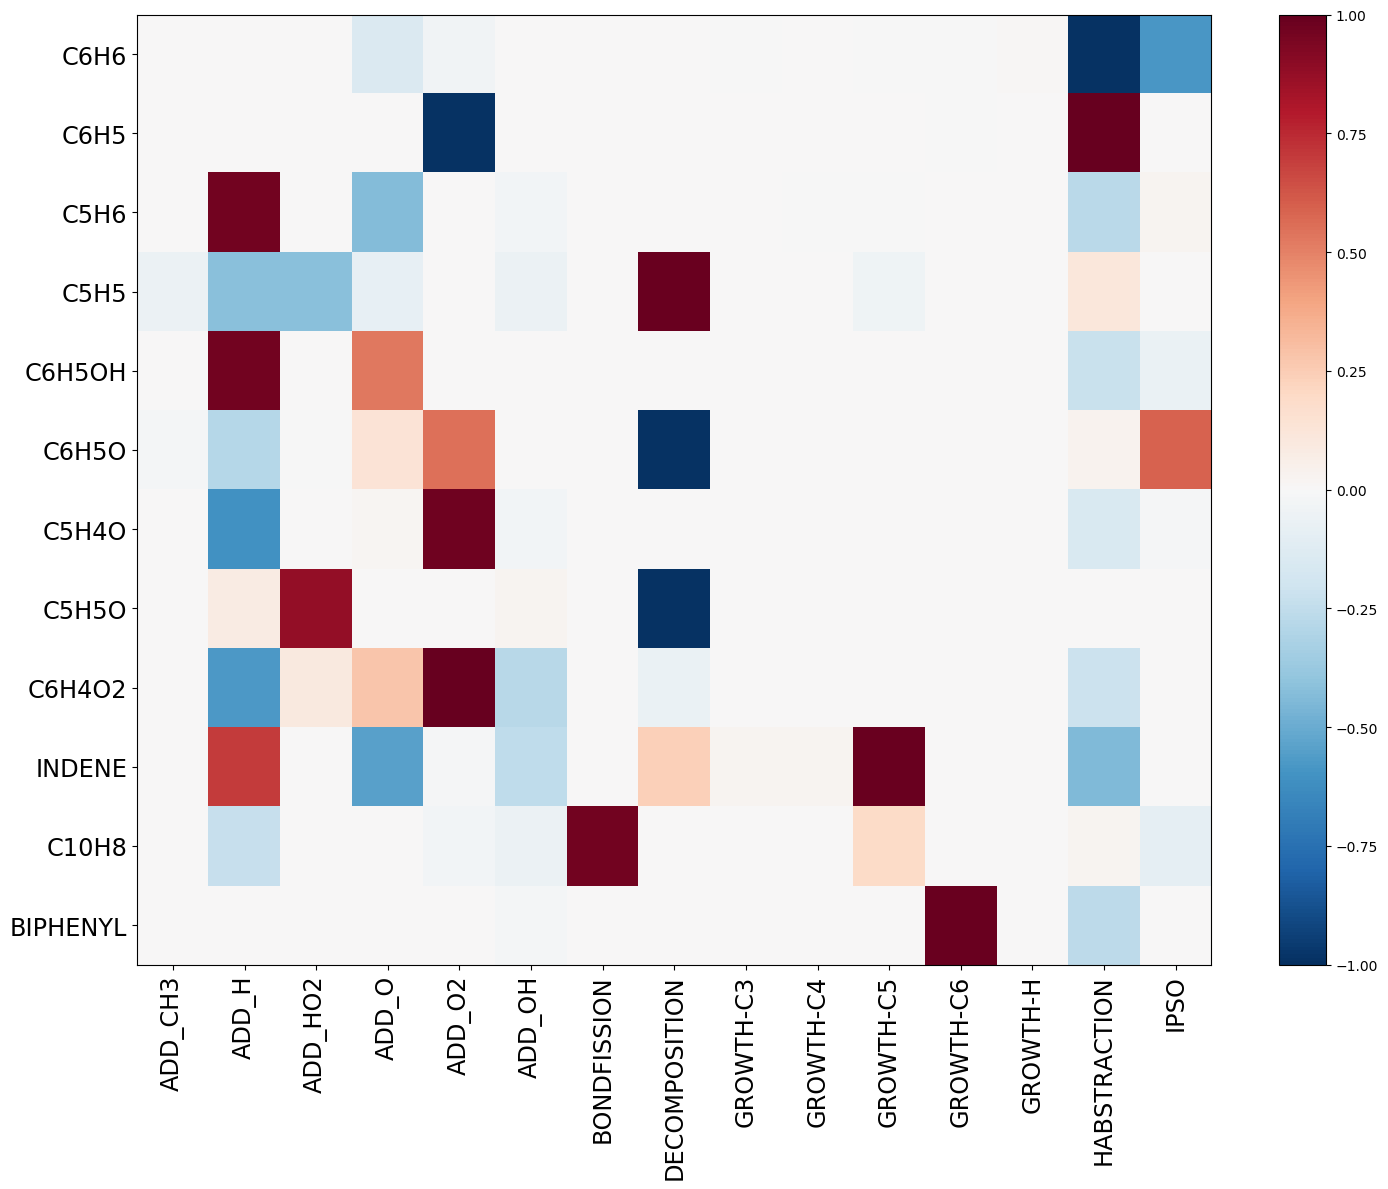

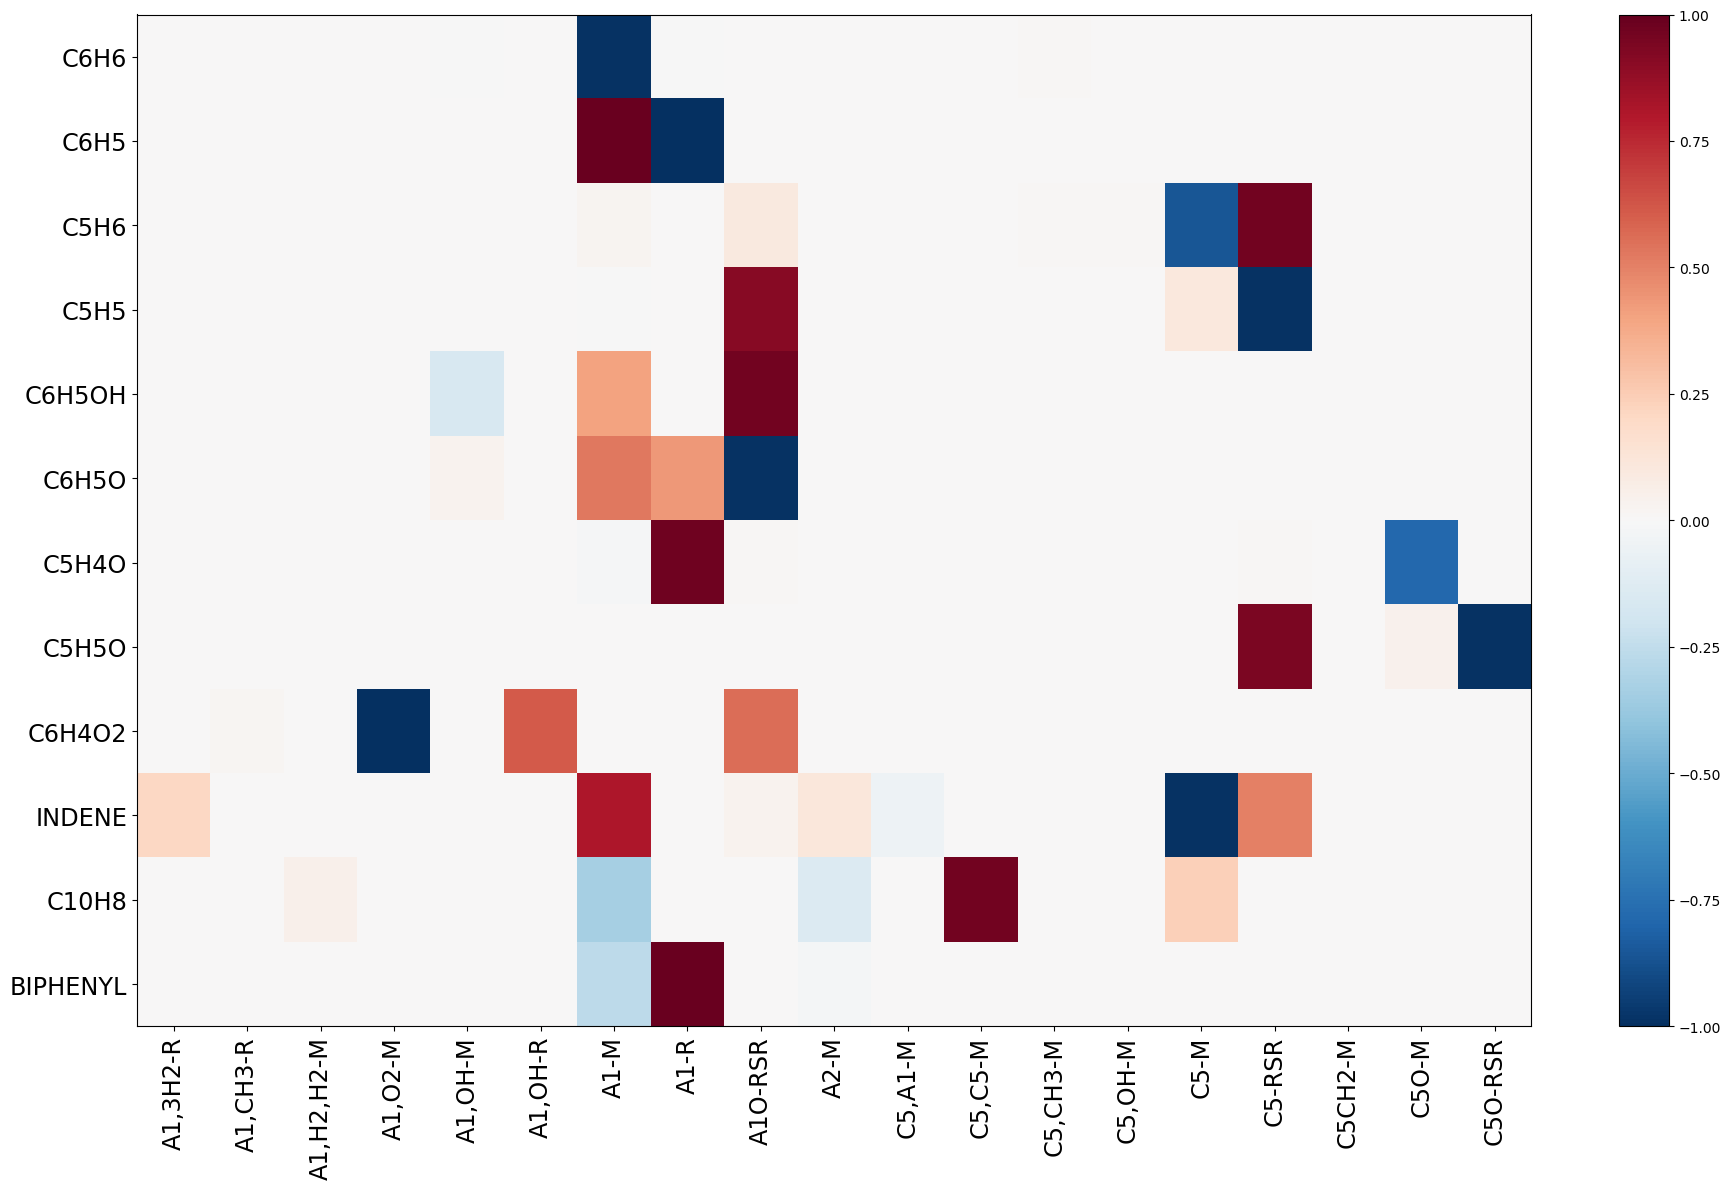

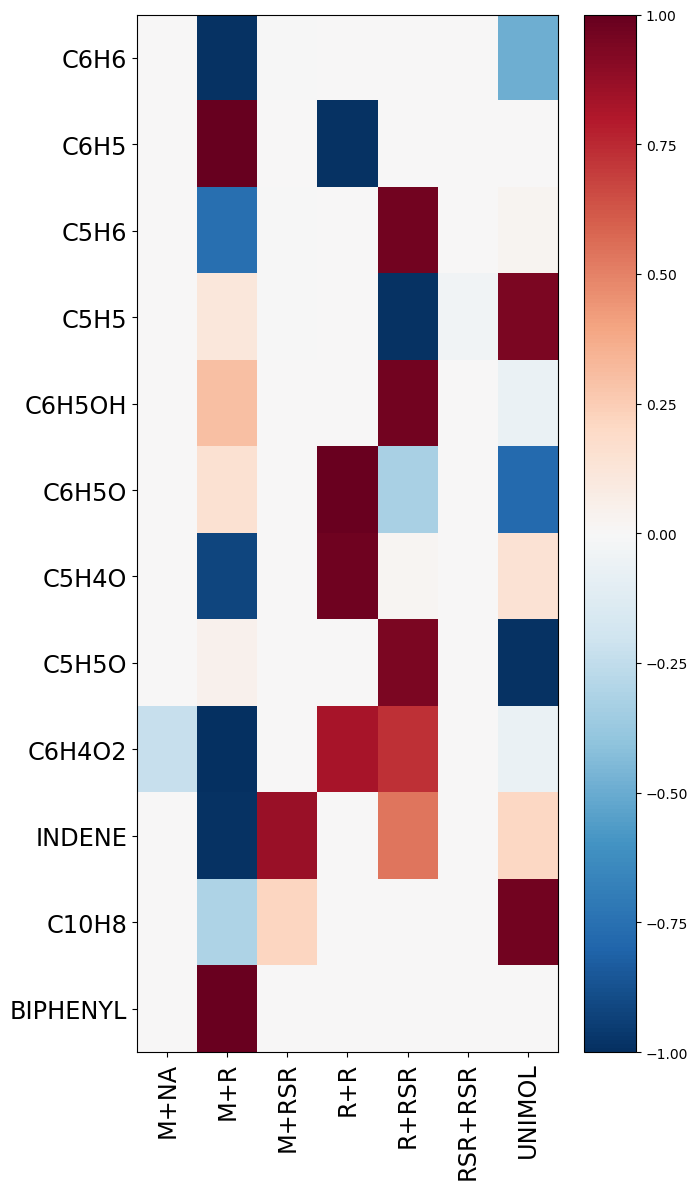

In [4]:
species_list =['C6H6','C6H5','C5H6','C5H5','C6H5OH','C6H5O','C5H4O','C5H5O','C6H4O2','INDENE','C10H8','BIPHENYL']
filter_dcts = [{},{},{}]   # filter according to selected criteria in name
threshs = [1e-2,1e-2,1e-2] # threshold for minimum flux
n_of_rxns = 200            # max n of rxns to consider for flux (default: 100)
sortlists = [['classtype'],['speciestype'],['bimoltype']] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                                                          # sum if both apply and sort by this criteria

# assign class
fluxbyclass = FluxByClass(kinetic_mechanism = kin_xml_fld, classes_definition = class_groups_fld, verbose = False)
# assign flux and process according to selected criteria
for simul_name, simul_fld in simul_flds.items():
    fluxbyclass.process_flux(species_list = species_list, results_folder = simul_fld, ropa_type = 'global')
    for i, sortlist in enumerate(sortlists):
        sortdf = fluxbyclass.sort_and_filter(sortlists[i], filter_dcts[i], threshs[i])
        # plot heatmap
        fig = plot_heatmap(sortdf)
        # save heatmap
        save_fig(fig, plt_fld, sortlist, simul_name)
        

**Example 2**: the reactions are now classified hierarchically according to [classtype][bimoltype]. The reactions are filtered such that only additions and abstraction reactions (of additions and abstraction class types) are considered. The threshold to filter the flux is 0.1%.

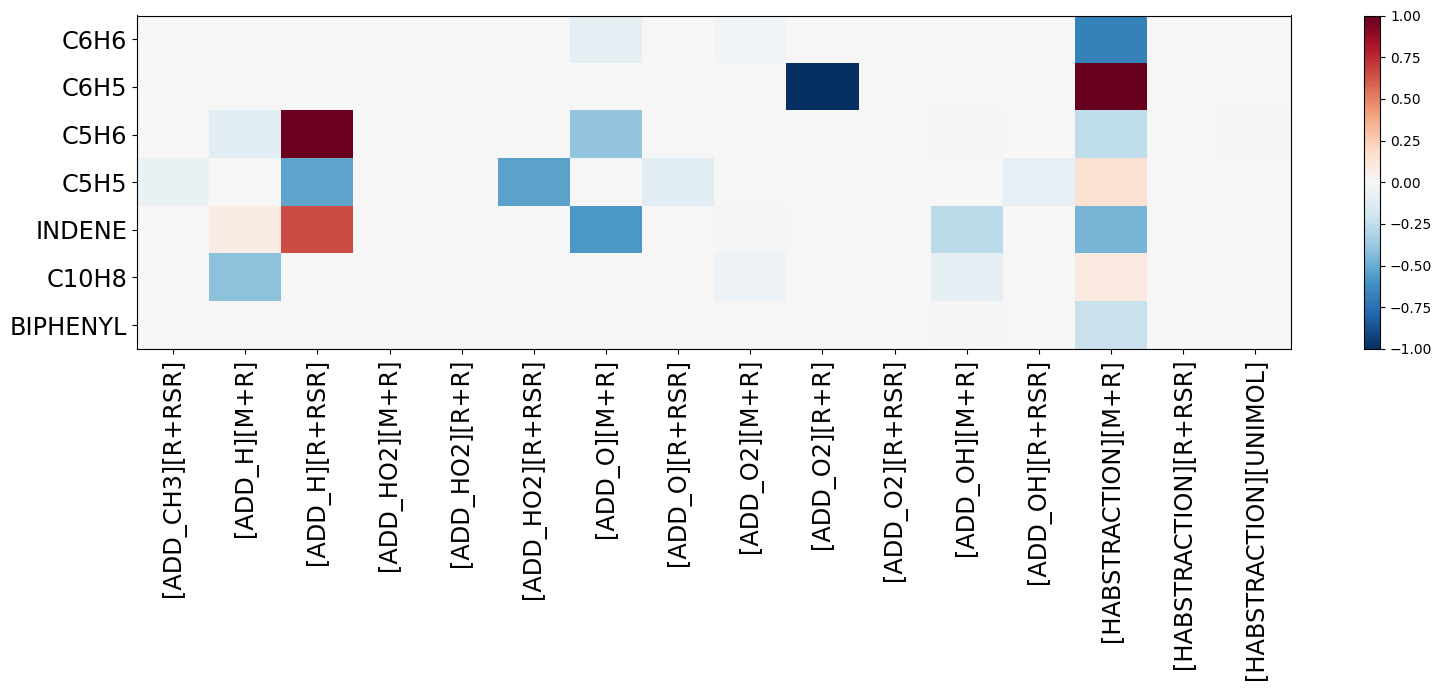

In [4]:
# additional type of classification: filter addition and abstraction reactions
species_list =['C6H6','C6H5','C5H6','C5H5','INDENE','C10H8','BIPHENYL']
filter_dct = {'classtype':['ADD', 'HABS']} # filter according to selected criteria in name
thresh = 1e-3 # threshold for minimum flux
sortlist = ['classtype','bimoltype'] # classtype, speciestype, subclass, bimoltype (R+R, RSR+RSR, M+M, ETC) sum if both apply and sort by this criteria

# assign class
fluxbyclass = FluxByClass(kinetic_mechanism = kin_xml_fld, classes_definition = class_groups_fld, verbose = False)
for simul_name, simul_fld in simul_flds.items():
    fluxbyclass.process_flux(species_list = species_list, results_folder = simul_fld, ropa_type = 'global')
    sortdf = fluxbyclass.sort_and_filter(sortlist, filter_dct, thresh)
    # plot heatmap
    fig = plot_heatmap(sortdf)
    # save heatmap
    save_fig(fig, plt_fld, sortlist, simul_name)


**Example 3** :do class analysis in a specific region or abscissa

What changes is essentially how the ropa_type is specified

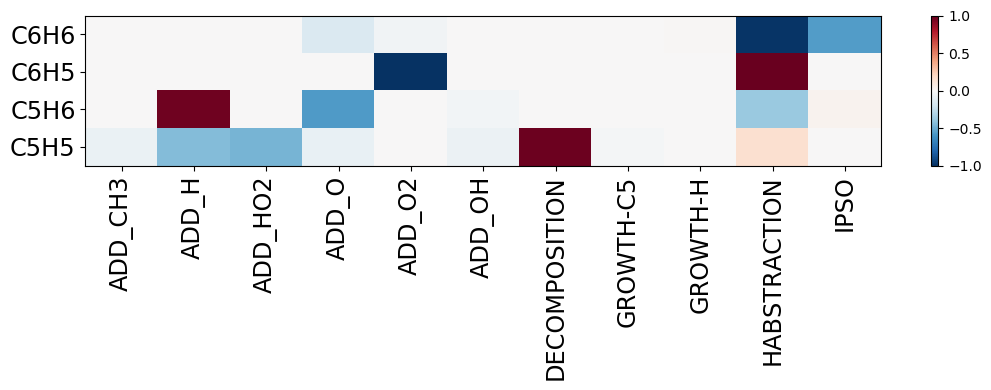

In [5]:
ropa_type = {'local': 0.1}
# ropa_type = {'region': [0.01, 0.1]}
species_list =['C6H6','C6H5','C5H6','C5H5']
filter_dct = {}   # filter according to selected criteria in name
thresh = 1e-2 # threshold for minimum flux
n_of_rxns = 200            # max n of rxns to consider for flux (default: 100)
sortlist = ['classtype'] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                                                          # sum if both apply and sort by this criteria
simul_fld = simul_flds['example-c6h6']
# assign class
fluxbyclass = FluxByClass(kinetic_mechanism = kin_xml_fld, classes_definition = class_groups_fld, verbose = False)

# assign flux and process according to selected criteria
fluxbyclass.process_flux(species_list = species_list, results_folder = simul_fld, ropa_type = ropa_type)
sortdf = fluxbyclass.sort_and_filter(sortlist, filter_dct, thresh)
# plot heatmap
fig = plot_heatmap(sortdf)
# save heatmap
save_fig(fig, plt_fld, sortlist, 'example-c6h6-local')

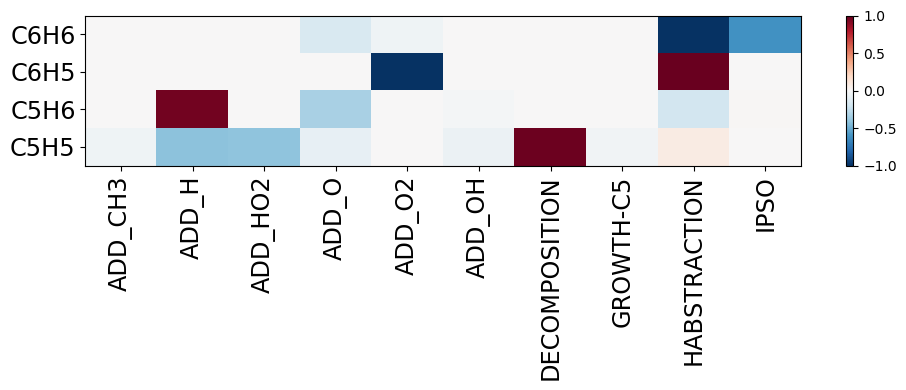

In [6]:
ropa_type = {'region': [0.01, 0.1]}
species_list =['C6H6','C6H5','C5H6','C5H5']
filter_dct = {}   # filter according to selected criteria in name
thresh = 1e-2 # threshold for minimum flux
n_of_rxns = 200            # max n of rxns to consider for flux (default: 100)
sortlist = ['classtype'] # classtype, speciestype, reactiontype, bimoltype (R+R, RSR+RSR, M+M, ETC) 
                                                          # sum if both apply and sort by this criteria
simul_fld = simul_flds['example-c6h6']
# assign class
fluxbyclass = FluxByClass(kinetic_mechanism = kin_xml_fld, classes_definition = class_groups_fld, verbose = False)

# assign flux and process according to selected criteria
fluxbyclass.process_flux(species_list = species_list, results_folder = simul_fld, ropa_type = ropa_type)
sortdf = fluxbyclass.sort_and_filter(sortlist, filter_dct, thresh)
# plot heatmap
fig = plot_heatmap(sortdf)
# save heatmap
save_fig(fig, plt_fld, sortlist, 'example-c6h6-region')